# Normal Mixture Models and the EM Algorithm

## Quantitative Risk Management - Week 2

This notebook implements:
1. Two-point normal mixture distributions
2. Expectation-Maximization (EM) algorithm for parameter estimation
3. Monte Carlo simulation for VaR and ES estimation
4. Comparison with standard normal distributions

### Theory Overview

A two-point normal mixture model assumes losses follow:
$$F(x) = \lambda F_1(x; \mu_1, \sigma_1^2) + (1-\lambda) F_2(x; \mu_2, \sigma_2^2)$$

where:
- $\lambda$ = probability of "good" regime
- $F_1$ = Normal distribution in good regime (low volatility)
- $F_2$ = Normal distribution in bad regime (high volatility)

This captures **leptokurtosis** (fat tails) observed in financial returns.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

## 1. Simulating from a Normal Mixture Model

### Pedagogical Parameters
We use clear parameter values to understand the model:

**Good Regime (70% probability):**
- Mean: μ₁ = 0.5%
- Std Dev: σ₁ = 1.5%

**Bad Regime (30% probability):**
- Mean: μ₂ = -1.0%
- Std Dev: σ₂ = 4.0%

In [3]:
class NormalMixtureModel:
    """
    Two-point Normal Mixture Model for losses/returns.
    
    Parameters:
    -----------
    lambda_: float
        Probability of regime 1 (0 < lambda < 1)
    mu1, mu2: float
        Means of the two normal distributions
    sigma1, sigma2: float
        Standard deviations of the two distributions
    """
    
    def __init__(self, lambda_, mu1, sigma1, mu2, sigma2):
        self.lambda_ = lambda_
        self.mu1 = mu1
        self.sigma1 = sigma1
        self.mu2 = mu2
        self.sigma2 = sigma2
        
    def simulate(self, n_samples, random_state=None):
        """
        Simulate from the mixture model.
        
        Algorithm (from lecture slide 22):
        1. Simulate regime indicators B_i ~ Bernoulli(lambda)
        2. Simulate standard normals Z_i ~ N(0,1)
        3. If B_i = 1: X_i = mu1 + sigma1 * Z_i
           If B_i = 0: X_i = mu2 + sigma2 * Z_i
        """
        if random_state is not None:
            np.random.seed(random_state)
            
        # Step 1: Simulate regime indicators
        regimes = np.random.binomial(1, self.lambda_, n_samples)
        
        # Step 2: Simulate standard normals
        z = np.random.standard_normal(n_samples)
        
        # Step 3: Generate mixture samples
        samples = np.where(regimes == 1,
                          self.mu1 + self.sigma1 * z,
                          self.mu2 + self.sigma2 * z)
        
        return samples, regimes
    
    def pdf(self, x):
        """Probability density function of the mixture."""
        pdf1 = stats.norm.pdf(x, self.mu1, self.sigma1)
        pdf2 = stats.norm.pdf(x, self.mu2, self.sigma2)
        return self.lambda_ * pdf1 + (1 - self.lambda_) * pdf2
    
    def cdf(self, x):
        """Cumulative distribution function of the mixture."""
        cdf1 = stats.norm.cdf(x, self.mu1, self.sigma1)
        cdf2 = stats.norm.cdf(x, self.mu2, self.sigma2)
        return self.lambda_ * cdf1 + (1 - self.lambda_) * cdf2
    
    def theoretical_moments(self):
        """
        Calculate theoretical moments (from slide 19).
        
        Returns:
        --------
        dict with mean, variance, skewness, kurtosis
        """
        # Mean
        mean = self.lambda_ * self.mu1 + (1 - self.lambda_) * self.mu2
        
        # Variance (slide 19 formula)
        var = (self.lambda_ * self.sigma1**2 + (1 - self.lambda_) * self.sigma2**2 +
               self.lambda_ * (1 - self.lambda_) * (self.mu1 - self.mu2)**2)
        
        std = np.sqrt(var)
        
        # For skewness and kurtosis, we need higher moments
        # Third central moment
        m1_3 = (self.mu1 - mean)**3 + 3*(self.mu1 - mean)*self.sigma1**2
        m2_3 = (self.mu2 - mean)**3 + 3*(self.mu2 - mean)*self.sigma2**2
        mu3 = self.lambda_ * m1_3 + (1 - self.lambda_) * m2_3
        
        # Fourth central moment
        m1_4 = (self.mu1 - mean)**4 + 6*(self.mu1 - mean)**2*self.sigma1**2 + 3*self.sigma1**4
        m2_4 = (self.mu2 - mean)**4 + 6*(self.mu2 - mean)**2*self.sigma2**2 + 3*self.sigma2**4
        mu4 = self.lambda_ * m1_4 + (1 - self.lambda_) * m2_4
        
        skewness = mu3 / std**3
        kurtosis = mu4 / var**2
        excess_kurtosis = kurtosis - 3
        
        return {
            'mean': mean,
            'variance': var,
            'std': std,
            'skewness': skewness,
            'kurtosis': kurtosis,
            'excess_kurtosis': excess_kurtosis
        }

In [4]:
# Define true parameters (pedagogical values)
TRUE_PARAMS = {
    'lambda_': 0.7,
    'mu1': 0.5,      # Good regime: small positive mean
    'sigma1': 1.5,   # Good regime: low volatility
    'mu2': -1.0,     # Bad regime: negative mean (losses)
    'sigma2': 4.0    # Bad regime: high volatility
}

# Create model instance
true_model = NormalMixtureModel(**TRUE_PARAMS)

# Display theoretical properties
print("="*60)
print("TRUE MODEL PARAMETERS")
print("="*60)
print(f"λ (good regime prob):  {TRUE_PARAMS['lambda_']:.3f}")
print(f"\nGood Regime (λ = {TRUE_PARAMS['lambda_']:.1%}):")
print(f"  μ₁ = {TRUE_PARAMS['mu1']:.2f}%")
print(f"  σ₁ = {TRUE_PARAMS['sigma1']:.2f}%")
print(f"\nBad Regime (λ = {1-TRUE_PARAMS['lambda_']:.1%}):")
print(f"  μ₂ = {TRUE_PARAMS['mu2']:.2f}%")
print(f"  σ₂ = {TRUE_PARAMS['sigma2']:.2f}%")
print("\n" + "="*60)
print("THEORETICAL MOMENTS")
print("="*60)
moments = true_model.theoretical_moments()
for key, value in moments.items():
    print(f"{key:20s}: {value:10.4f}")
print("\nNote: Excess kurtosis > 0 indicates fat tails (leptokurtosis)")

TRUE MODEL PARAMETERS
λ (good regime prob):  0.700

Good Regime (λ = 70.0%):
  μ₁ = 0.50%
  σ₁ = 1.50%

Bad Regime (λ = 30.0%):
  μ₂ = -1.00%
  σ₂ = 4.00%

THEORETICAL MOMENTS
mean                :     0.0500
variance            :     6.8475
std                 :     2.6168
skewness            :    -0.7410
kurtosis            :     5.8669
excess_kurtosis     :     2.8669

Note: Excess kurtosis > 0 indicates fat tails (leptokurtosis)


## 2. Monte Carlo Simulation and Visualization

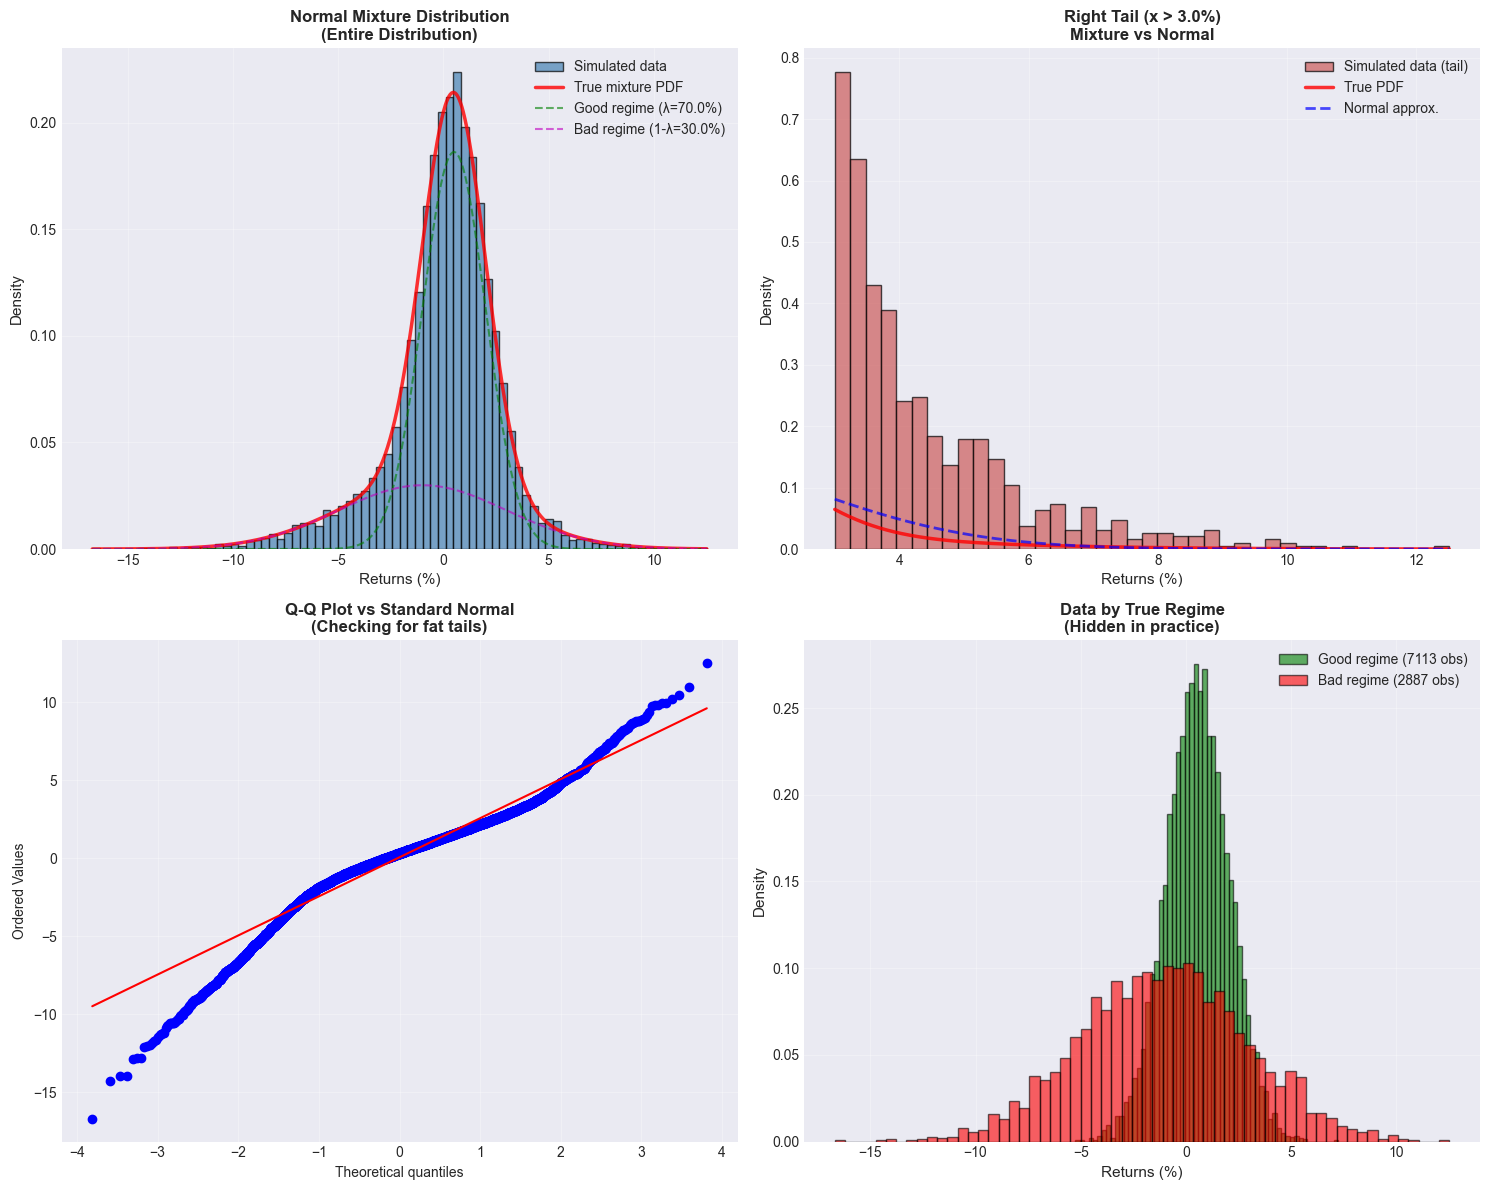


SAMPLE vs THEORETICAL MOMENTS (N=10,000)
Moment                     Sample  Theoretical   Difference
------------------------------------------------------------
Mean                       0.0724       0.0500       0.0224
Std Dev                    2.5767       2.6168      -0.0400
Skewness                  -0.8185      -0.7410      -0.0775
Kurtosis                   5.8772       5.8669       0.0102


In [5]:
# Generate large sample for analysis
N_SAMPLES = 10000
samples, regimes = true_model.simulate(N_SAMPLES, random_state=42)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram with theoretical density
ax = axes[0, 0]
ax.hist(samples, bins=80, density=True, alpha=0.7, 
        color='steelblue', edgecolor='black', label='Simulated data')
x_range = np.linspace(samples.min(), samples.max(), 1000)
ax.plot(x_range, true_model.pdf(x_range), 'r-', lw=2.5, 
        label='True mixture PDF', alpha=0.8)

# Overlay component distributions
pdf1 = stats.norm.pdf(x_range, TRUE_PARAMS['mu1'], TRUE_PARAMS['sigma1'])
pdf2 = stats.norm.pdf(x_range, TRUE_PARAMS['mu2'], TRUE_PARAMS['sigma2'])
ax.plot(x_range, TRUE_PARAMS['lambda_'] * pdf1, 'g--', 
        lw=1.5, label=f'Good regime (λ={TRUE_PARAMS["lambda_"]:.1%})', alpha=0.6)
ax.plot(x_range, (1-TRUE_PARAMS['lambda_']) * pdf2, 'm--', 
        lw=1.5, label=f'Bad regime (1-λ={1-TRUE_PARAMS["lambda_"]:.1%})', alpha=0.6)

ax.set_xlabel('Returns (%)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Normal Mixture Distribution\n(Entire Distribution)', fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# 2. Zoomed-in right tail
ax = axes[0, 1]
tail_threshold = 3.0
tail_samples = samples[samples > tail_threshold]
ax.hist(tail_samples, bins=40, density=True, alpha=0.7,
        color='indianred', edgecolor='black', label='Simulated data (tail)')
x_tail = np.linspace(tail_threshold, samples.max(), 500)
ax.plot(x_tail, true_model.pdf(x_tail), 'r-', lw=2.5, label='True PDF', alpha=0.8)

# Compare with normal approximation
normal_pdf = stats.norm.pdf(x_tail, samples.mean(), samples.std())
ax.plot(x_tail, normal_pdf, 'b--', lw=2, label='Normal approx.', alpha=0.7)

ax.set_xlabel('Returns (%)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title(f'Right Tail (x > {tail_threshold}%)\nMixture vs Normal', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Q-Q plot vs Normal (from slide 12)
ax = axes[1, 0]
stats.probplot(samples, dist="norm", plot=ax)
ax.set_title('Q-Q Plot vs Standard Normal\n(Checking for fat tails)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Regime classification
ax = axes[1, 1]
regime1_samples = samples[regimes == 1]
regime2_samples = samples[regimes == 0]
ax.hist(regime1_samples, bins=60, density=True, alpha=0.6, 
        color='green', label=f'Good regime ({len(regime1_samples)} obs)', edgecolor='black')
ax.hist(regime2_samples, bins=60, density=True, alpha=0.6,
        color='red', label=f'Bad regime ({len(regime2_samples)} obs)', edgecolor='black')
ax.set_xlabel('Returns (%)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Data by True Regime\n(Hidden in practice)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mixture_distribution_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare sample vs theoretical moments
print("\n" + "="*60)
print("SAMPLE vs THEORETICAL MOMENTS (N=10,000)")
print("="*60)
print(f"{'Moment':<20} {'Sample':>12} {'Theoretical':>12} {'Difference':>12}")
print("-"*60)
sample_mean = samples.mean()
sample_std = samples.std()
sample_skew = stats.skew(samples)
sample_kurt = stats.kurtosis(samples, fisher=False)  # Pearson kurtosis

print(f"{'Mean':<20} {sample_mean:>12.4f} {moments['mean']:>12.4f} {sample_mean - moments['mean']:>12.4f}")
print(f"{'Std Dev':<20} {sample_std:>12.4f} {moments['std']:>12.4f} {sample_std - moments['std']:>12.4f}")
print(f"{'Skewness':<20} {sample_skew:>12.4f} {moments['skewness']:>12.4f} {sample_skew - moments['skewness']:>12.4f}")
print(f"{'Kurtosis':<20} {sample_kurt:>12.4f} {moments['kurtosis']:>12.4f} {sample_kurt - moments['kurtosis']:>12.4f}")

## 3. Expectation-Maximization (EM) Algorithm

### Algorithm Overview (from slides 26-31)

The EM algorithm solves the MLE problem when regimes are unobserved:

**Challenge:** Log-likelihood has a sum inside the logarithm:
$$\log L = \sum_{i=1}^n \log[\lambda f_1(x_i) + (1-\lambda)f_2(x_i)]$$

**Solution:** Iterate between:
- **E-step:** Calculate regime probabilities given current parameters
- **M-step:** Update parameters given regime probabilities

### E-Step (Slide 30)
Calculate conditional probability that observation $i$ came from regime 1:
$$p_i^{(t)} = \frac{\lambda^{(t)} f_1(x_i; \mu_1^{(t)}, \sigma_1^{(t)})}{\lambda^{(t)} f_1(x_i; \mu_1^{(t)}, \sigma_1^{(t)}) + (1-\lambda^{(t)}) f_2(x_i; \mu_2^{(t)}, \sigma_2^{(t)})}$$

### M-Step (Slide 31)
Update parameters using weighted MLE:
$$\lambda^{(t+1)} = \frac{1}{n}\sum_{i=1}^n p_i^{(t)}$$
$$\mu_1^{(t+1)} = \frac{\sum_{i=1}^n x_i p_i^{(t)}}{\sum_{i=1}^n p_i^{(t)}}$$
$$(\sigma_1^{(t+1)})^2 = \frac{\sum_{i=1}^n (x_i - \mu_1^{(t+1)})^2 p_i^{(t)}}{\sum_{i=1}^n p_i^{(t)}}$$

In [6]:
class EMAlgorithm:
    """
    EM Algorithm for estimating Normal Mixture Model parameters.
    
    Implementation follows slides 26-31.
    """
    
    def __init__(self, max_iter=1000, tol=1e-6, verbose=True):
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.history = []
        
    def initialize_params(self, data, method='kmeans'):
        """
        Initialize parameters. Good initialization is crucial!
        
        Methods:
        - 'random': Random initialization
        - 'kmeans': Use k-means clustering (more stable)
        """
        if method == 'random':
            lambda_ = np.random.uniform(0.3, 0.7)
            mu1 = np.random.normal(data.mean(), data.std())
            mu2 = np.random.normal(data.mean(), data.std())
            sigma1 = np.random.uniform(data.std()/2, data.std())
            sigma2 = np.random.uniform(data.std(), data.std()*2)
        elif method == 'kmeans':
            from sklearn.cluster import KMeans
            kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
            labels = kmeans.fit_predict(data.reshape(-1, 1))
            
            cluster1 = data[labels == 0]
            cluster2 = data[labels == 1]
            
            lambda_ = len(cluster1) / len(data)
            mu1 = cluster1.mean()
            mu2 = cluster2.mean()
            sigma1 = cluster1.std()
            sigma2 = cluster2.std()
        
        return lambda_, mu1, sigma1, mu2, sigma2
    
    def e_step(self, data, lambda_, mu1, sigma1, mu2, sigma2):
        """
        E-step: Calculate regime probabilities (slide 30).
        
        Returns p_i = P(regime 1 | x_i, params)
        """
        # Calculate densities for each component
        pdf1 = stats.norm.pdf(data, mu1, sigma1)
        pdf2 = stats.norm.pdf(data, mu2, sigma2)
        
        # Calculate conditional probabilities (Bayes' rule)
        numerator = lambda_ * pdf1
        denominator = lambda_ * pdf1 + (1 - lambda_) * pdf2
        
        # Avoid division by zero
        p_regime1 = np.divide(numerator, denominator, 
                             out=np.ones_like(numerator)*0.5,
                             where=denominator!=0)
        
        return p_regime1
    
    def m_step(self, data, p_regime1):
        """
        M-step: Update parameters (slide 31).
        
        Uses weighted MLE formulas.
        """
        n = len(data)
        p_regime2 = 1 - p_regime1
        
        # Update lambda
        lambda_new = p_regime1.sum() / n
        
        # Update mu1, mu2
        mu1_new = (data * p_regime1).sum() / p_regime1.sum()
        mu2_new = (data * p_regime2).sum() / p_regime2.sum()
        
        # Update sigma1, sigma2
        sigma1_new = np.sqrt(((data - mu1_new)**2 * p_regime1).sum() / p_regime1.sum())
        sigma2_new = np.sqrt(((data - mu2_new)**2 * p_regime2).sum() / p_regime2.sum())
        
        return lambda_new, mu1_new, sigma1_new, mu2_new, sigma2_new
    
    def log_likelihood(self, data, lambda_, mu1, sigma1, mu2, sigma2):
        """
        Calculate log-likelihood (slide 31).
        
        log L = sum_i log[lambda * f1(x_i) + (1-lambda) * f2(x_i)]
        """
        pdf1 = stats.norm.pdf(data, mu1, sigma1)
        pdf2 = stats.norm.pdf(data, mu2, sigma2)
        mixture_pdf = lambda_ * pdf1 + (1 - lambda_) * pdf2
        
        # Avoid log(0)
        mixture_pdf = np.maximum(mixture_pdf, 1e-300)
        
        return np.sum(np.log(mixture_pdf))
    
    def fit(self, data, init_method='kmeans', n_restarts=5):
        """
        Fit the model using EM algorithm with multiple random restarts.
        
        Multiple restarts help avoid local maxima (slide 33).
        """
        best_loglik = -np.inf
        best_params = None
        best_history = None
        
        for restart in range(n_restarts):
            if self.verbose:
                print(f"\nRestart {restart + 1}/{n_restarts}")
                print("-" * 50)
            
            # Initialize
            lambda_, mu1, sigma1, mu2, sigma2 = self.initialize_params(data, init_method)
            
            history = []
            loglik = self.log_likelihood(data, lambda_, mu1, sigma1, mu2, sigma2)
            history.append({
                'iter': 0,
                'loglik': loglik,
                'lambda': lambda_,
                'mu1': mu1, 'sigma1': sigma1,
                'mu2': mu2, 'sigma2': sigma2
            })
            
            # EM iterations
            for iteration in range(1, self.max_iter + 1):
                # E-step
                p_regime1 = self.e_step(data, lambda_, mu1, sigma1, mu2, sigma2)
                
                # M-step
                lambda_, mu1, sigma1, mu2, sigma2 = self.m_step(data, p_regime1)
                
                # Calculate log-likelihood
                loglik_new = self.log_likelihood(data, lambda_, mu1, sigma1, mu2, sigma2)
                
                history.append({
                    'iter': iteration,
                    'loglik': loglik_new,
                    'lambda': lambda_,
                    'mu1': mu1, 'sigma1': sigma1,
                    'mu2': mu2, 'sigma2': sigma2
                })
                
                # Check convergence (slide 31)
                if abs(loglik_new - loglik) < self.tol:
                    if self.verbose:
                        print(f"Converged at iteration {iteration}")
                        print(f"Final log-likelihood: {loglik_new:.4f}")
                    break
                    
                loglik = loglik_new
                
                if self.verbose and iteration % 20 == 0:
                    print(f"Iter {iteration:3d}: log-lik = {loglik_new:.4f}")
            
            # Keep best result
            if loglik_new > best_loglik:
                best_loglik = loglik_new
                best_params = (lambda_, mu1, sigma1, mu2, sigma2)
                best_history = history
        
        self.history = best_history
        return best_params

### Fitting the Model to Simulated Data

In [7]:
# Generate estimation sample (smaller than before)
N_ESTIMATION = 2000
estimation_data, _ = true_model.simulate(N_ESTIMATION, random_state=123)

# Run EM algorithm
print("="*60)
print("FITTING MODEL USING EM ALGORITHM")
print("="*60)
print(f"Sample size: {N_ESTIMATION:,}")
print(f"Number of restarts: 5")

em = EMAlgorithm(max_iter=200, tol=1e-6, verbose=True)
lambda_hat, mu1_hat, sigma1_hat, mu2_hat, sigma2_hat = em.fit(estimation_data, 
                                                                init_method='kmeans',
                                                                n_restarts=5)

FITTING MODEL USING EM ALGORITHM
Sample size: 2,000
Number of restarts: 5

Restart 1/5
--------------------------------------------------


  File "C:\Users\athay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Iter  20: log-lik = -4510.4979
Converged at iteration 40
Final log-likelihood: -4510.4977

Restart 2/5
--------------------------------------------------
Iter  20: log-lik = -4510.4979
Converged at iteration 40
Final log-likelihood: -4510.4977

Restart 3/5
--------------------------------------------------
Iter  20: log-lik = -4510.4979
Converged at iteration 40
Final log-likelihood: -4510.4977

Restart 4/5
--------------------------------------------------
Iter  20: log-lik = -4510.4979
Converged at iteration 40
Final log-likelihood: -4510.4977

Restart 5/5
--------------------------------------------------
Iter  20: log-lik = -4510.4979
Converged at iteration 40
Final log-likelihood: -4510.4977


In [8]:
# Compare estimated vs true parameters
print("\n" + "="*70)
print("PARAMETER ESTIMATION RESULTS")
print("="*70)
print(f"{'Parameter':<15} {'True':>12} {'Estimated':>12} {'Error':>12} {'Error %':>12}")
print("-"*70)

params_comparison = [
    ('λ', TRUE_PARAMS['lambda_'], lambda_hat),
    ('μ₁', TRUE_PARAMS['mu1'], mu1_hat),
    ('σ₁', TRUE_PARAMS['sigma1'], sigma1_hat),
    ('μ₂', TRUE_PARAMS['mu2'], mu2_hat),
    ('σ₂', TRUE_PARAMS['sigma2'], sigma2_hat),
]

for name, true_val, est_val in params_comparison:
    error = est_val - true_val
    error_pct = (error / true_val * 100) if true_val != 0 else 0
    print(f"{name:<15} {true_val:>12.4f} {est_val:>12.4f} {error:>12.4f} {error_pct:>11.2f}%")

# Note on label switching
print("\n" + "="*70)
print("NOTE: If parameters appear swapped, this is 'label switching' - ")
print("      the EM algorithm found the same model but swapped regime labels.")
print("      This is normal and doesn't affect the mixture distribution.")
print("="*70)


PARAMETER ESTIMATION RESULTS
Parameter               True    Estimated        Error      Error %
----------------------------------------------------------------------
λ                     0.7000       0.2650      -0.4350      -62.15%
μ₁                    0.5000      -0.9422      -1.4422     -288.44%
σ₁                    1.5000       4.0143       2.5143      167.62%
μ₂                   -1.0000       0.4692       1.4692     -146.92%
σ₂                    4.0000       1.5270      -2.4730      -61.82%

NOTE: If parameters appear swapped, this is 'label switching' - 
      the EM algorithm found the same model but swapped regime labels.
      This is normal and doesn't affect the mixture distribution.


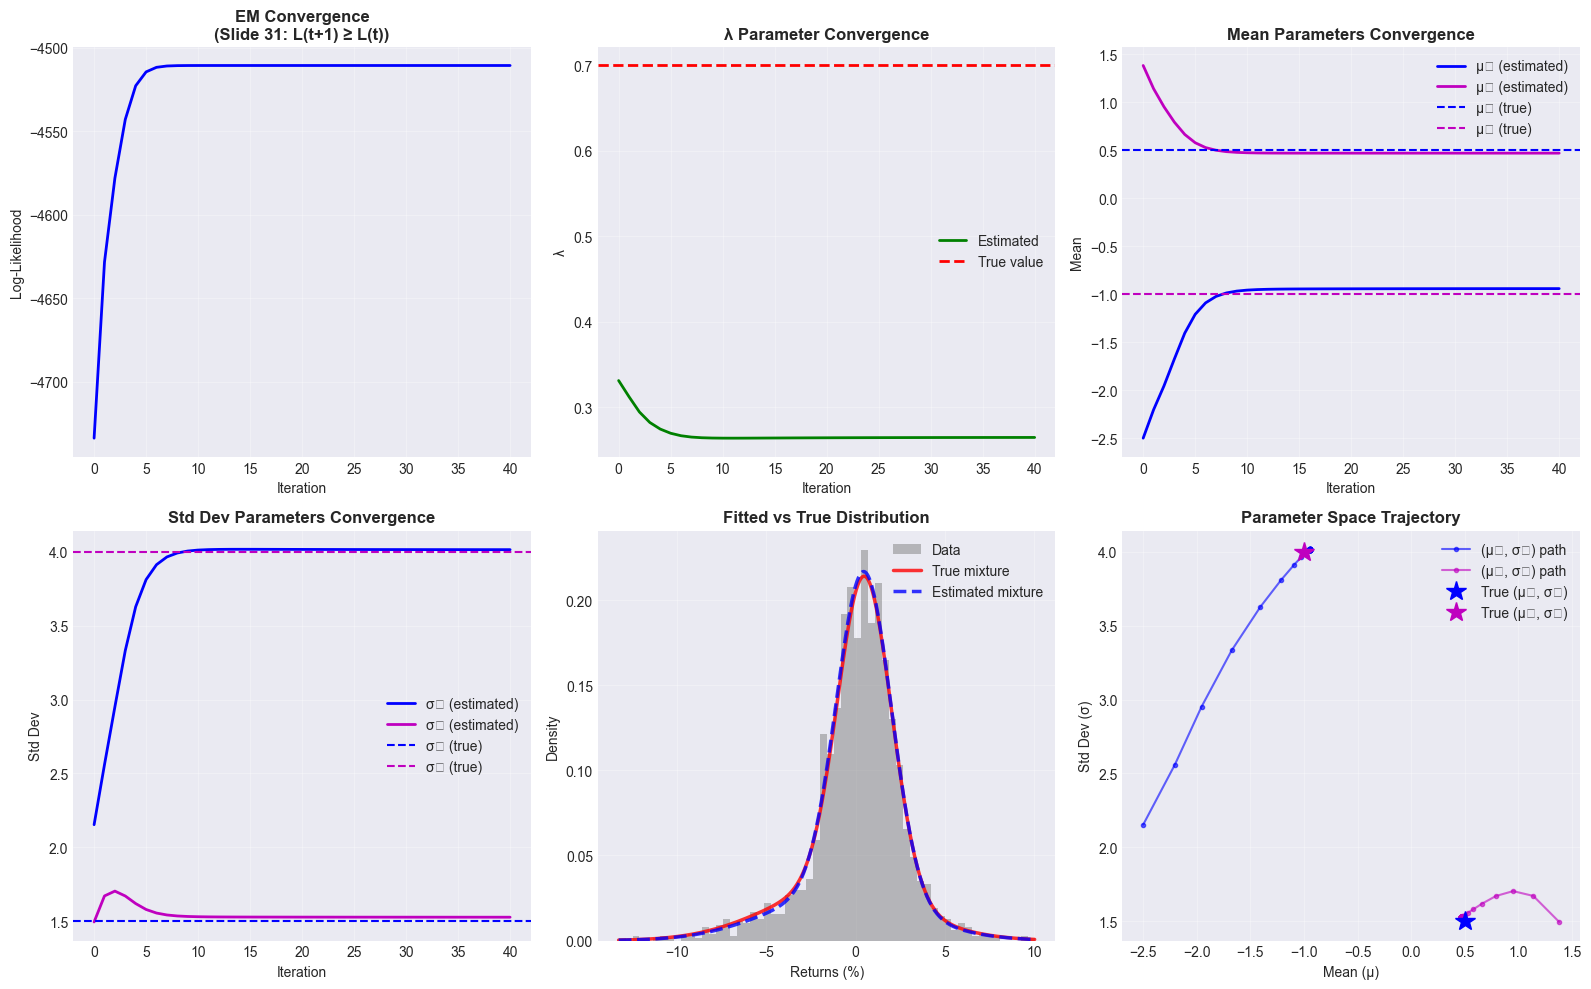

In [9]:
# Visualize EM convergence
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

history_df = pd.DataFrame(em.history)

# Log-likelihood convergence
ax = axes[0, 0]
ax.plot(history_df['iter'], history_df['loglik'], 'b-', lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Log-Likelihood')
ax.set_title('EM Convergence\n(Slide 31: L(t+1) ≥ L(t))', fontweight='bold')
ax.grid(True, alpha=0.3)

# Lambda convergence
ax = axes[0, 1]
ax.plot(history_df['iter'], history_df['lambda'], 'g-', lw=2, label='Estimated')
ax.axhline(TRUE_PARAMS['lambda_'], color='r', linestyle='--', lw=2, label='True value')
ax.set_xlabel('Iteration')
ax.set_ylabel('λ')
ax.set_title('λ Parameter Convergence', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Mu convergence
ax = axes[0, 2]
ax.plot(history_df['iter'], history_df['mu1'], 'b-', lw=2, label='μ₁ (estimated)')
ax.plot(history_df['iter'], history_df['mu2'], 'm-', lw=2, label='μ₂ (estimated)')
ax.axhline(TRUE_PARAMS['mu1'], color='b', linestyle='--', lw=1.5, label='μ₁ (true)')
ax.axhline(TRUE_PARAMS['mu2'], color='m', linestyle='--', lw=1.5, label='μ₂ (true)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Mean')
ax.set_title('Mean Parameters Convergence', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Sigma convergence
ax = axes[1, 0]
ax.plot(history_df['iter'], history_df['sigma1'], 'b-', lw=2, label='σ₁ (estimated)')
ax.plot(history_df['iter'], history_df['sigma2'], 'm-', lw=2, label='σ₂ (estimated)')
ax.axhline(TRUE_PARAMS['sigma1'], color='b', linestyle='--', lw=1.5, label='σ₁ (true)')
ax.axhline(TRUE_PARAMS['sigma2'], color='m', linestyle='--', lw=1.5, label='σ₂ (true)')
ax.set_xlabel('Iteration')
ax.set_ylabel('Std Dev')
ax.set_title('Std Dev Parameters Convergence', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Fitted vs True density
ax = axes[1, 1]
ax.hist(estimation_data, bins=60, density=True, alpha=0.5, 
        color='gray', label='Data')
x_range = np.linspace(estimation_data.min(), estimation_data.max(), 500)

# True density
true_pdf = true_model.pdf(x_range)
ax.plot(x_range, true_pdf, 'r-', lw=2.5, label='True mixture', alpha=0.8)

# Estimated density
estimated_model = NormalMixtureModel(lambda_hat, mu1_hat, sigma1_hat, mu2_hat, sigma2_hat)
est_pdf = estimated_model.pdf(x_range)
ax.plot(x_range, est_pdf, 'b--', lw=2.5, label='Estimated mixture', alpha=0.8)

ax.set_xlabel('Returns (%)')
ax.set_ylabel('Density')
ax.set_title('Fitted vs True Distribution', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Parameter trajectory in 2D space
ax = axes[1, 2]
ax.plot(history_df['mu1'], history_df['sigma1'], 'bo-', markersize=3, lw=1.5, 
        alpha=0.6, label='(μ₁, σ₁) path')
ax.plot(history_df['mu2'], history_df['sigma2'], 'mo-', markersize=3, lw=1.5,
        alpha=0.6, label='(μ₂, σ₂) path')
ax.plot(TRUE_PARAMS['mu1'], TRUE_PARAMS['sigma1'], 'b*', markersize=15, 
        label='True (μ₁, σ₁)')
ax.plot(TRUE_PARAMS['mu2'], TRUE_PARAMS['sigma2'], 'm*', markersize=15,
        label='True (μ₂, σ₂)')
ax.set_xlabel('Mean (μ)')
ax.set_ylabel('Std Dev (σ)')
ax.set_title('Parameter Space Trajectory', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('em_convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Monte Carlo VaR and ES Estimation

### Methodology (from slides 20-22)

1. **Simulate large sample** from the fitted mixture model (m = 100,000)
2. **Calculate VaR** using empirical quantile (Historical Simulation on simulated data)
3. **Calculate ES** as average of losses beyond VaR
4. **Convergence analysis**: How does estimate improve with m?

In [10]:
def monte_carlo_risk_measures(model, n_simulations, confidence_levels, random_state=None):
    """
    Calculate VaR and ES using Monte Carlo simulation.
    
    Parameters:
    -----------
    model: NormalMixtureModel
        Fitted mixture model
    n_simulations: int
        Number of MC samples
    confidence_levels: list
        List of confidence levels (e.g., [0.95, 0.99, 0.995])
    
    Returns:
    --------
    DataFrame with VaR and ES estimates
    """
    # Simulate from model
    simulated_losses, _ = model.simulate(n_simulations, random_state=random_state)
    
    results = []
    
    for alpha in confidence_levels:
        # VaR: empirical quantile (Historical Simulation method)
        var = np.percentile(simulated_losses, alpha * 100)
        
        # ES: average of losses exceeding VaR
        tail_losses = simulated_losses[simulated_losses >= var]
        es = tail_losses.mean() if len(tail_losses) > 0 else var
        
        results.append({
            'Confidence': f"{alpha:.1%}",
            'Alpha': alpha,
            'VaR': var,
            'ES': es,
            'ES/VaR': es/var if var != 0 else np.nan,
            'N_tail': len(tail_losses)
        })
    
    return pd.DataFrame(results)

# Calculate risk measures for true and estimated models
CONFIDENCE_LEVELS = [0.90, 0.95, 0.975, 0.99, 0.995, 0.999]
N_MC = 100000

print("="*80)
print(f"MONTE CARLO RISK MEASURES (N = {N_MC:,} simulations)")
print("="*80)

# True model
print("\nTRUE MODEL:")
true_risk = monte_carlo_risk_measures(true_model, N_MC, CONFIDENCE_LEVELS, random_state=42)
print(true_risk.to_string(index=False))

# Estimated model
print("\n" + "="*80)
print("ESTIMATED MODEL:")
estimated_risk = monte_carlo_risk_measures(estimated_model, N_MC, CONFIDENCE_LEVELS, random_state=43)
print(estimated_risk.to_string(index=False))

# Comparison
print("\n" + "="*80)
print("ESTIMATION ERROR:")
print("="*80)
comparison = pd.DataFrame({
    'Confidence': true_risk['Confidence'],
    'VaR_Error': estimated_risk['VaR'] - true_risk['VaR'],
    'VaR_Error_%': ((estimated_risk['VaR'] - true_risk['VaR']) / true_risk['VaR'] * 100),
    'ES_Error': estimated_risk['ES'] - true_risk['ES'],
    'ES_Error_%': ((estimated_risk['ES'] - true_risk['ES']) / true_risk['ES'] * 100)
})
print(comparison.to_string(index=False))

MONTE CARLO RISK MEASURES (N = 100,000 simulations)

TRUE MODEL:
Confidence  Alpha      VaR        ES   ES/VaR  N_tail
     90.0%  0.900 2.734821  4.175417 1.526761   10000
     95.0%  0.950 3.632043  5.228689 1.439600    5000
     97.5%  0.975 4.683844  6.385774 1.363362    2500
     99.0%  0.990 6.381198  7.894039 1.237078    1000
     99.5%  0.995 7.490486  8.899556 1.188115     500
     99.9%  0.999 9.709949 11.000143 1.132873     100

ESTIMATED MODEL:
Confidence  Alpha      VaR        ES   ES/VaR  N_tail
     90.0%  0.900 2.693064  4.124847 1.531656   10000
     95.0%  0.950 3.542529  5.186959 1.464196    5000
     97.5%  0.975 4.591770  6.388618 1.391319    2500
     99.0%  0.990 6.332875  8.001603 1.263503    1000
     99.5%  0.995 7.624776  9.100423 1.193533     500
     99.9%  0.999 9.970103 11.272060 1.130586     100

ESTIMATION ERROR:
Confidence  VaR_Error  VaR_Error_%  ES_Error  ES_Error_%
     90.0%  -0.041757    -1.526847 -0.050570   -1.211144
     95.0%  -0.089514    -2.

### Monte Carlo Convergence Analysis


Analyzing MC convergence for VaR99%...
Running 50 replications for each sample size...


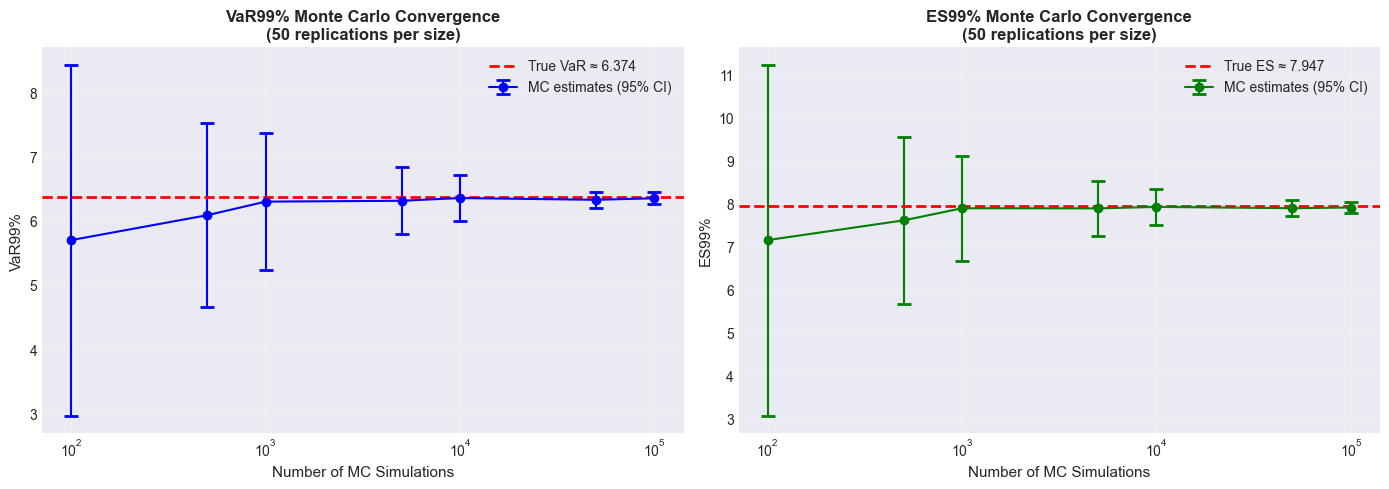


Convergence Summary:
     n  var_mean  var_std  es_mean   es_std
   100  5.698174 1.394846 7.150143 2.085978
   500  6.085647 0.731141 7.609072 0.995531
  1000  6.297263 0.545004 7.891373 0.621670
  5000  6.310436 0.264725 7.888547 0.328381
 10000  6.353122 0.185147 7.923321 0.212017
 50000  6.325471 0.064797 7.892900 0.095505
100000  6.349352 0.048774 7.908990 0.065002


In [11]:
# Analyze convergence as function of sample size
sample_sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]
target_alpha = 0.99
n_replications = 50  # Repeat each sample size to get variability

print(f"\nAnalyzing MC convergence for VaR{target_alpha:.0%}...")
print(f"Running {n_replications} replications for each sample size...")

convergence_results = []

for n in sample_sizes:
    var_estimates = []
    es_estimates = []
    
    for rep in range(n_replications):
        result = monte_carlo_risk_measures(true_model, n, [target_alpha], 
                                           random_state=rep)
        var_estimates.append(result['VaR'].iloc[0])
        es_estimates.append(result['ES'].iloc[0])
    
    convergence_results.append({
        'n': n,
        'var_mean': np.mean(var_estimates),
        'var_std': np.std(var_estimates),
        'es_mean': np.mean(es_estimates),
        'es_std': np.std(es_estimates)
    })

convergence_df = pd.DataFrame(convergence_results)

# Plot convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get "true" value from very large sample
true_mc = monte_carlo_risk_measures(true_model, 500000, [target_alpha], random_state=999)
true_var = true_mc['VaR'].iloc[0]
true_es = true_mc['ES'].iloc[0]

# VaR convergence
ax = axes[0]
ax.errorbar(convergence_df['n'], convergence_df['var_mean'], 
            yerr=1.96*convergence_df['var_std'], 
            fmt='bo-', capsize=5, capthick=2, label='MC estimates (95% CI)')
ax.axhline(true_var, color='r', linestyle='--', lw=2, label=f'True VaR ≈ {true_var:.3f}')
ax.set_xscale('log')
ax.set_xlabel('Number of MC Simulations', fontsize=11)
ax.set_ylabel(f'VaR{target_alpha:.0%}', fontsize=11)
ax.set_title(f'VaR{target_alpha:.0%} Monte Carlo Convergence\n({n_replications} replications per size)', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# ES convergence
ax = axes[1]
ax.errorbar(convergence_df['n'], convergence_df['es_mean'],
            yerr=1.96*convergence_df['es_std'],
            fmt='go-', capsize=5, capthick=2, label='MC estimates (95% CI)')
ax.axhline(true_es, color='r', linestyle='--', lw=2, label=f'True ES ≈ {true_es:.3f}')
ax.set_xscale('log')
ax.set_xlabel('Number of MC Simulations', fontsize=11)
ax.set_ylabel(f'ES{target_alpha:.0%}', fontsize=11)
ax.set_title(f'ES{target_alpha:.0%} Monte Carlo Convergence\n({n_replications} replications per size)',
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mc_convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConvergence Summary:")
print(convergence_df.to_string(index=False))

## 5. Comparison with Normal Model

### Why Mixture Models Matter

Compare risk measures from:
1. **Normal Mixture** (captures leptokurtosis)
2. **Standard Normal** (traditional approach, underestimates tail risk)

In [12]:
# Fit normal distribution to the same data
normal_mean = estimation_data.mean()
normal_std = estimation_data.std()

print("="*80)
print("NORMAL vs MIXTURE MODEL COMPARISON")
print("="*80)

# Calculate risk measures for normal model
normal_risk_measures = []
for alpha in CONFIDENCE_LEVELS:
    # VaR from normal: mean + z_alpha * std
    z_alpha = stats.norm.ppf(alpha)
    var_normal = normal_mean + z_alpha * normal_std
    
    # ES from normal: mean + phi(z_alpha)/((1-alpha)) * std
    es_normal = normal_mean + (stats.norm.pdf(z_alpha) / (1 - alpha)) * normal_std
    
    normal_risk_measures.append({
        'Confidence': f"{alpha:.1%}",
        'VaR_Normal': var_normal,
        'ES_Normal': es_normal
    })

normal_df = pd.DataFrame(normal_risk_measures)

# Combine with mixture estimates
comparison_df = pd.merge(
    estimated_risk[['Confidence', 'VaR', 'ES']], 
    normal_df, 
    on='Confidence'
)
comparison_df['VaR_Underest_%'] = ((comparison_df['VaR_Normal'] - comparison_df['VaR']) / 
                                    comparison_df['VaR'] * 100)
comparison_df['ES_Underest_%'] = ((comparison_df['ES_Normal'] - comparison_df['ES']) / 
                                   comparison_df['ES'] * 100)

print("\nRisk Measure Comparison:")
print(comparison_df.to_string(index=False))
print("\nNegative % = Normal model UNDERESTIMATES tail risk")
print("(Normal ignores fat tails from mixture structure)")

NORMAL vs MIXTURE MODEL COMPARISON

Risk Measure Comparison:
Confidence      VaR        ES  VaR_Normal  ES_Normal  VaR_Underest_%  ES_Underest_%
     90.0% 2.693064  4.124847    3.330150   4.525193       23.656538       9.705708
     95.0% 3.542529  5.186959    4.247202   5.301967       19.891790       2.217263
     97.5% 4.591770  6.388618    5.042607   5.996353        9.818378      -6.140051
     99.0% 6.332875  8.001603    5.967439   6.822809       -5.770461     -14.731968
     99.5% 7.624776  9.100423    6.597183   7.395135      -13.477023     -18.738550
     99.9% 9.970103 11.272060    7.895646   8.594494      -20.806780     -23.754011

Negative % = Normal model UNDERESTIMATES tail risk
(Normal ignores fat tails from mixture structure)


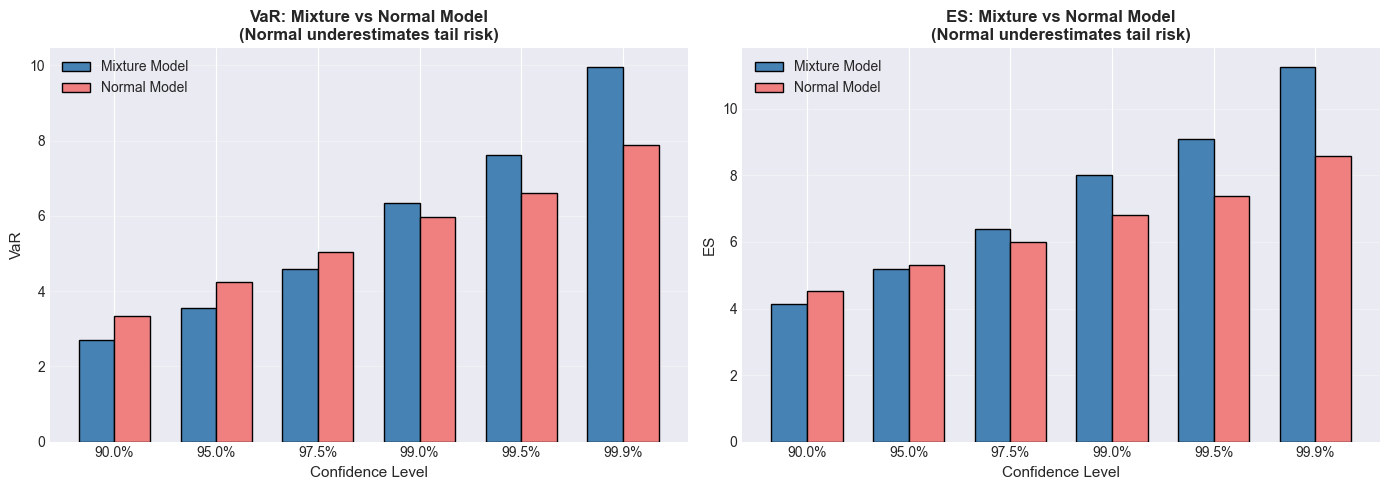

In [13]:
# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# VaR comparison
ax = axes[0]
x = np.arange(len(CONFIDENCE_LEVELS))
width = 0.35
ax.bar(x - width/2, comparison_df['VaR'], width, label='Mixture Model', 
       color='steelblue', edgecolor='black')
ax.bar(x + width/2, comparison_df['VaR_Normal'], width, label='Normal Model',
       color='lightcoral', edgecolor='black')
ax.set_xlabel('Confidence Level', fontsize=11)
ax.set_ylabel('VaR', fontsize=11)
ax.set_title('VaR: Mixture vs Normal Model\n(Normal underestimates tail risk)', 
             fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Confidence'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# ES comparison
ax = axes[1]
ax.bar(x - width/2, comparison_df['ES'], width, label='Mixture Model',
       color='steelblue', edgecolor='black')
ax.bar(x + width/2, comparison_df['ES_Normal'], width, label='Normal Model',
       color='lightcoral', edgecolor='black')
ax.set_xlabel('Confidence Level', fontsize=11)
ax.set_ylabel('ES', fontsize=11)
ax.set_title('ES: Mixture vs Normal Model\n(Normal underestimates tail risk)',
             fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Confidence'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('mixture_vs_normal_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Key Takeaways

### Normal Mixture Models
- Capture **leptokurtosis** (fat tails) and **skewness** in financial returns
- Simple two-regime interpretation: "good times" vs "bad times"
- NOT the same as normal distribution (slide 17)

### EM Algorithm
- Solves MLE when regimes are **hidden/unobserved**
- Iterates between E-step (guess regimes) and M-step (update parameters)
- Guaranteed to improve likelihood: $L^{(t+1)} \geq L^{(t)}$
- Multiple random restarts help avoid local maxima

### Monte Carlo Risk Estimation
- VaR: Empirical quantile of simulated losses
- ES: Average of tail losses beyond VaR
- Convergence improves with $\sqrt{n}$
- For 99.9% quantiles, need 100,000+ simulations

### Practical Implications
- Normal models **systematically underestimate tail risk**
- Underestimation worsens at extreme quantiles (99%+)
- Critical for emerging markets with regime-switching volatility

## 7. Exercises

### Exercise 1: Sensitivity Analysis
Modify the true parameters to create a more asymmetric mixture (e.g., λ=0.9, very different means). How does this affect:
- Skewness?
- EM convergence speed?
- Difference between Normal and Mixture VaR?

### Exercise 2: Three-Component Mixture
Extend the code to handle three regimes (good/normal/bad). What challenges arise in:
- Parameter initialization?
- Convergence?
- Label switching?

### Exercise 3: Real Data Application
Download emerging market equity returns (e.g., MSCI Emerging Markets index). 
- Fit both normal and mixture models
- Compare VaR/ES estimates
- Validate with actual crisis events

### Exercise 4: Exponential Mixture (Slide 72 Problem 1)
Implement the EM algorithm for exponential mixture distributions as described in the homework.